In [ ]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import json
import math

%matplotlib inline
%config IPCompleter.greedy=True

pd.set_option('display.max_colwidth', -1)

In [4]:
G = nx.MultiGraph()

In [5]:
# functions

# function to calculate points from segment length
def points(distance):
    x = [0, 1, 2, 4, 7, 0, 15, 0, 21]
    return x[distance]

def inverse_weight(distance):
    return(1/distance)

# distance of path p in graph g
def distance_of_path(g, p):
    d = sum([g.edges[p[e],p[e+1],0]['distance'] for e in range(len(p)-1)])
    return d

# points of path p in graph g
def points_of_path(g, p):
    d = sum([g.edges[p[e],p[e+1],0]['points'] for e in range(len(p)-1)])
    return d

In [73]:
# construct graph

G.clear()

with open(routes_path) as f:
    for line in f:
        city1, city2, distance, route_type, color, is_multi = pattern.findall(line)
        distance = int(distance)
        if(G.has_edge(city1,city2)==False):
            G.add_edge(city1, city2, key=0, distance=distance, route_type=route_type, color=color, points=points(distance), 
                   weight=distance, importance=0)
        else:
            G.add_edge(city1, city2, key=1, distance=distance, route_type=route_type, color=color, points=points(distance), 
                   weight=distance, importance=0)       

In [64]:
# construct shortest paths of destinations
temp=list()
with open(destinations_path) as f:
    for line in f:
        source, destination, card_points = pattern.findall(line)
        card_points=int(card_points)
        p1=list()
        points1=0
        distance1=0
        for p in nx.all_shortest_paths(G,source,destination,weight='weight'):
            _points=points_of_path(G,p)
            if(_points>points1):
                points1=_points
                distance1=distance_of_path(G,p)
                p1=p
        total_points=card_points+points1
        temp.append((source,destination,card_points,distance1,total_points,'-'.join(p1)))
        
destinations_df = pd.DataFrame.from_records(temp, columns=['source','destination','card_points','min_req_trains','total_points','path'])
del temp

#  calculate points-per-capita
destinations_df['points_per_capita'] = destinations_df.apply(lambda row: round(row['total_points']/row['min_req_trains'],2), axis=1)

# connectivity
destinations_df['connectivity'] = destinations_df.apply(lambda row: nx.edge_connectivity(G,row['source'],row['destination']), axis=1)

In [65]:
destinations_df.sort_values(['total_points'],ascending=False).head(10)

,source,destination,card_points,min_req_trains,total_points,path,points_per_capita,connectivity
42,Palermo,Moskva,20,20,54,Palermo-Smyrna-Constantinople-Bucuresti-Kyiv-Smolensk-Moskva,2.70,3
43,Kobenhavn,Erzurum,21,21,53,Kobenhavn-Essen-Berlin-Wien-Budapest-Bucuresti-Sevastopol-Erzurum,2.52,2
45,Cadiz,Stockholm,21,21,50,Cadiz-Madrid-Pamplona-Paris-Frankfurt-Essen-Kobenhavn-Stockholm,2.38,2
41,Brest,Petrograd,20,20,50,Brest-Paris-Frankfurt-Berlin-Danzig-Riga-Petrograd,2.50,3
40,Lisboa,Danzig,20,20,50,Lisboa-Madrid-Pamplona-Paris-Frankfurt-Berlin-Danzig,2.50,2
44,Edinburgh,Athina,21,20,48,Edinburgh-London-Dieppe-Paris-Zurich-Venezia-Roma-Brindisi-Athina,2.40,1
39,Frankfurt,Smolensk,13,13,32,Frankfurt-Berlin-Warszawa-Wilno-Smolensk,2.46,3
38,Amsterdam,Wilno,12,12,29,Amsterdam-Frankfurt-Berlin-Warszawa-Wilno,2.42,4
37,Berlin,Moskva,12,12,29,Berlin-Warszawa-Wilno-Smolensk-Moskva,2.42,3
32,Essen,Kyiv,10,10,26,Essen-Berlin-Warszawa-Kyiv,2.60,4


In [27]:
# compare all paths between given cities
temp = list()
for p in nx.all_shortest_paths(G,'Lisboa','Rostov',weight=None):
    distance=distance_of_path(G,p)
    points1=points_of_path(G,p)
    per_capita=round(points1/distance,2)
    temp.append((p,distance,points1,per_capita))

temp_df = pd.DataFrame.from_records(temp,columns=['path','min_req_trains','points','points_per_capita'])
del temp

temp_df.sort_values(['points_per_capita'],ascending=False).head(5)

,path,min_req_trains,points,points_per_capita
0,"[Lisboa, Madrid, Barcelona, Marseille, Roma, Palermo, Smyrna, Constantinople, Sevastopol, Rostov]",33,58,1.76
1,"[Lisboa, Madrid, Pamplona, Marseille, Roma, Palermo, Smyrna, Constantinople, Sevastopol, Rostov]",34,60,1.76
2,"[Lisboa, Madrid, Pamplona, Paris, Frankfurt, Berlin, Warszawa, Kyiv, Kharkov, Rostov]",30,46,1.53


In [32]:
# betweenness centrality

bc = nx.betweenness_centrality(G)
top_bc = dict(sorted(bc.items(), key=lambda x: x[1], reverse=True)[:5])
#print(json.dumps(top_bc, indent=4))

for k,v in top_bc.items():
    print('{} - {}'.format(k,v))

Frankfurt - 0.21109636740071516
Paris - 0.20014705369777835
Berlin - 0.19125180375180373
Kyiv - 0.18437449024405547
Marseille - 0.15295250643076733


In [37]:
nx.diameter(G)

9

In [39]:
ecc = nx.eccentricity(G)
ecc = dict(sorted(ecc.items(), key=lambda x: x[1], reverse=True))
print(json.dumps(ecc, indent=4))

{
    "Lisboa": 9,
    "Cadiz": 9,
    "Edinburgh": 9,
    "Erzurum": 9,
    "Sochi": 9,
    "Rostov": 9,
    "Moskva": 9,
    "Madrid": 8,
    "Barcelona": 8,
    "Brest": 8,
    "Dieppe": 8,
    "London": 8,
    "Angora": 8,
    "Sevastopol": 8,
    "Constantinople": 8,
    "Bucuresti": 8,
    "Kharkov": 8,
    "Smolensk": 8,
    "Petrograd": 8,
    "Sofia": 8,
    "Pamplona": 7,
    "Marseille": 7,
    "Paris": 7,
    "Bruxelles": 7,
    "Amsterdam": 7,
    "Smyrna": 7,
    "Kyiv": 7,
    "Wilno": 7,
    "Budapest": 7,
    "Riga": 7,
    "Stockholm": 7,
    "Palermo": 7,
    "Athina": 7,
    "Kobenhavn": 7,
    "Sarajevo": 7,
    "Brindisi": 7,
    "Warszawa": 6,
    "Danzig": 6,
    "Essen": 6,
    "Wien": 6,
    "Zagrab": 6,
    "Roma": 6,
    "Frankfurt": 6,
    "Zurich": 6,
    "Berlin": 5,
    "Venezia": 5,
    "Munchen": 5
}


In [41]:
#node clustering co-efficient for each city
ccoef = nx.clustering(G)
print(json.dumps(ccoef, indent=4))

NetworkXNotImplemented: not implemented for multigraph type

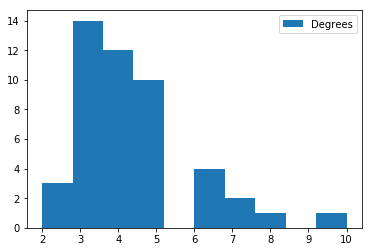

In [45]:
#histogram of degrees for all nodes
degree_list = [G.degree[n] for n in G.nodes(data=False)]

plt.hist(degree_list, label="Degrees")
plt.legend(loc='upper right')

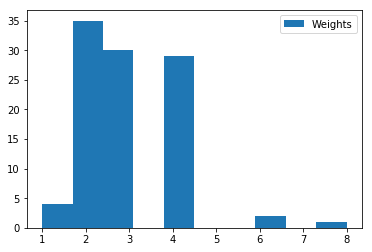

In [46]:
#histogram of weights for all nodes
weights_list = [d['weight'] for u,v,d in G.edges(data=True)]

plt.hist(weights_list, label="Weights")
plt.legend(loc='upper right')

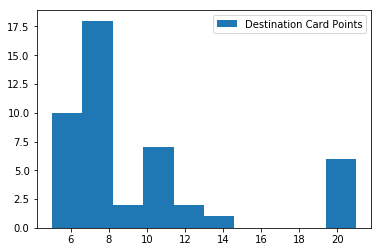

In [47]:
# histogram of destination cards points
card_points = [row['card_points'] for idx,row in destinations_df.iterrows()]

plt.hist(card_points, label="Destination Card Points")
plt.legend(loc='upper right')

In [48]:
nx.node_connectivity(G)

1

In [49]:
nx.edge_connectivity(G)

1

In [61]:
print(nx.edge_connectivity(G,'Palermo','Moskva'))

3


In [78]:
list(nx.minimum_edge_cut(G,'Erzurum','Angora'))

[('Erzurum', 'Angora'), ('Constantinople', 'Angora'), ('Smyrna', 'Angora')]

In [81]:
# calc edge importance from min edge cut's
for idx,row in destinations_df.iterrows():
    for min_cut in list(nx.minimum_edge_cut(G,row['source'],row['destination'])):
        u, v = min_cut
        G.edges[u,v,0]['importance']+=1

In [86]:
for u, v, d in sorted(G.edges(data=True), key=lambda x: x[2]['importance'], reverse=True)[:10]:
    print('{u}-{v} {imp}'.format(u=u, v=v, imp=d['importance']))

Madrid-Pamplona 5
Petrograd-Stockholm 5
Pamplona-Brest 4
Moskva-Smolensk 4
Kobenhavn-Essen 4
Madrid-Barcelona 3
Barcelona-Marseille 3
Paris-Brest 3
Brest-Dieppe 3
Dieppe-London 3


In [90]:
# edge-betweenness centrality

ebc = nx.edge_betweenness_centrality(G,weight='weight')
top_ebc = dict(sorted(ebc.items(), key=lambda x: x[1], reverse=True)[:5])

for k,v in top_ebc.items():
    print('{} - {}'.format(k,v))

('Berlin', 'Frankfurt') - 0.1405088448913611
('Marseille', 'Roma') - 0.13431056301084057
('Paris', 'Frankfurt') - 0.13328581173169515
('Warszawa', 'Berlin') - 0.11138325904745887
('Kyiv', 'Warszawa') - 0.09926518388590547


In [143]:
def candidate_vertices(g, u, v):
    d = math.floor(nx.shortest_path_length(g, u, v)/2 + 1)
    p1 = [c for c in nx.bfs_tree(g, u, depth_limit=d)]
    p2 = [c for c in nx.bfs_tree(g, u, depth_limit=d)]
    s = set(p1) & set(p2)
    s.add(u)
    s.add(v)
    return s
   
# Score all paths between u and v in graph g up to distance min(u,v)+1
def best_scoring_paths(g, u, v):
    #gs = g.subgraph(nodes = candidate_vertices(g, u, v))
    #print(nx.info(g))
    #print(nx.info(gs))
    #gs.remove_multiple_edges()
    sp_length=nx.shortest_path_length(g,u,v)
    paths = nx.all_simple_paths(g, u, v, cutoff=sp_length+2)
    return [{'path': x, 'length': len(x), 'points': points_of_path(g, x), 'score': float(points_of_path(g, x)/len(x))} for x in paths]
    #return [{'path': x, 'length': len(x), 'points': points_of_path(gs, x), 'score': float(points_of_path(gs, x)/len(x))} for x in paths]

In [ ]:
#Ref https://github.com/alphajuliet/ticket-to-ride/blob/master/ttr.ipynb

In [144]:
x = best_scoring_paths(G, 'Palermo', 'Moskva')
print(len(x))
x.sort(key = lambda x: x['score'], reverse = True)
x[0:10]

131


[{'path': ['Palermo',
   'Smyrna',
   'Constantinople',
   'Sevastopol',
   'Bucuresti',
   'Budapest',
   'Kyiv',
   'Kharkov',
   'Moskva'],
  'length': 9,
  'points': 67,
  'score': 7.444444444444445},
 {'path': ['Palermo',
   'Smyrna',
   'Constantinople',
   'Bucuresti',
   'Budapest',
   'Kyiv',
   'Kharkov',
   'Moskva'],
  'length': 8,
  'points': 57,
  'score': 7.125},
 {'path': ['Palermo',
   'Smyrna',
   'Athina',
   'Sarajevo',
   'Budapest',
   'Kyiv',
   'Kharkov',
   'Moskva'],
  'length': 8,
  'points': 57,
  'score': 7.125},
 {'path': ['Palermo',
   'Smyrna',
   'Angora',
   'Constantinople',
   'Bucuresti',
   'Budapest',
   'Kyiv',
   'Kharkov',
   'Moskva'],
  'length': 9,
  'points': 61,
  'score': 6.777777777777778},
 {'path': ['Palermo',
   'Smyrna',
   'Constantinople',
   'Sevastopol',
   'Bucuresti',
   'Budapest',
   'Kyiv',
   'Smolensk',
   'Moskva'],
  'length': 9,
  'points': 59,
  'score': 6.555555555555555},
 {'path': ['Palermo',
   'Smyrna',
   'Consta

In [135]:
nx.shortest_path_length(G, 'Palermo', 'Moskva')

6

In [137]:
for p in nx.all_simple_paths(G,'Palermo','Moskva',cutoff=8):
    print(p)

['Palermo', 'Smyrna', 'Angora', 'Erzurum', 'Sevastopol', 'Sochi', 'Rostov', 'Kharkov', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Erzurum', 'Sevastopol', 'Bucuresti', 'Kyiv', 'Kharkov', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Erzurum', 'Sevastopol', 'Bucuresti', 'Kyiv', 'Smolensk', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Erzurum', 'Sevastopol', 'Rostov', 'Kharkov', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Erzurum', 'Sochi', 'Sevastopol', 'Rostov', 'Kharkov', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Erzurum', 'Sochi', 'Rostov', 'Kharkov', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Constantinople', 'Sevastopol', 'Sochi', 'Rostov', 'Kharkov', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Constantinople', 'Sevastopol', 'Bucuresti', 'Kyiv', 'Kharkov', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Constantinople', 'Sevastopol', 'Bucuresti', 'Kyiv', 'Smolensk', 'Moskva']
['Palermo', 'Smyrna', 'Angora', 'Constantinople', 'Sevastopol', 'Rostov', 'Kharkov', 'Moskva']
['Palermo', 'Smyrna', 'A